In [1]:
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from pylab import rcParams
from matplotlib import pyplot as plt
import numpy as np
import scipy
from scipy import sparse
from scipy import linalg
from scipy import special, pi
from scipy import integrate
from scipy.fft import fft, fftshift, fftfreq, ifft, ifft2, fft2, ifftshift
from scipy import signal
import os

In [84]:
au2cm = 219474.6305
auScale= 0.0000046
au2fs = 0.02418884254
scaling = 1.0

t_short = 10000 #(1.0e3 / au2fs) / scaling
t_learn = (1.0e3 / au2fs) / scaling
t_min = (1.0e-3 / au2fs) / scaling

n_pts = 1000
n_ltc = 10

#learn_domain = np.logspace(np.log2(t_min), np.log2(t_learn), num=n_pts, base=2)
#test_domain = np.logspace(np.log2(t_min), np.log2(t_test), num=n_pts, base=2)
learn_domain = np.linspace(0, t_learn, num=n_pts)
learn_domain_short = np.linspace(0, t_short, num=n_pts)
print(t_learn)

41341.37457575099


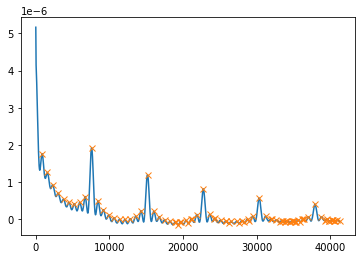

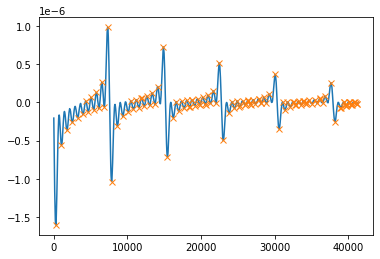

In [3]:
file_learn = open('learn_db_10_lin.csv', 'r')#for lin space x distribution
#file_learn = open('learn_db_4_lin.csv', 'r')
learn_s, test_s,learn_a, test_a = np.loadtxt(file_learn ,delimiter = ",")
os.environ["KMP_DUPLICATE_LIB_OK"] = "True"
peak_s, a = signal.find_peaks(learn_s)
peak_a, a = signal.find_peaks(abs(learn_a))
plt.plot(learn_domain, learn_s)
plt.plot(learn_domain[peak_s], learn_s[peak_s], "x")
#plt.xscale('log')
plt.show()
plt.plot(learn_domain, learn_a)
plt.plot(learn_domain[peak_a], learn_a[peak_a], "x")
#plt.xscale('log')
plt.show()

<Figure size 1440x1440 with 0 Axes>

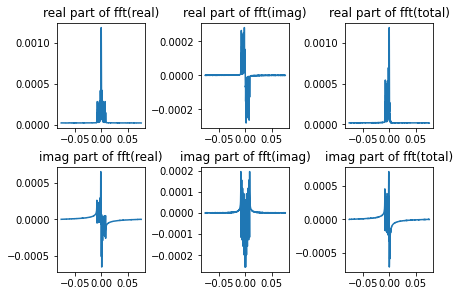

In [4]:
learn_r = torch.Tensor(learn_s)
learn_i = torch.Tensor(learn_a)

learn_r = torch.complex(learn_r, torch.zeros((1000,))).detach().numpy()
#print(learn_r)
learn_i = torch.complex(torch.zeros((1000,)), learn_i).detach().numpy()

ft_shift_r = 2*np.pi*fftshift(fft(learn_r))
ft_shift_i = 2*np.pi*fftshift(fft(learn_i))
#annot_max(freq_r, ft_r)
n = np.arange(-n_pts/2, n_pts/2)
freq = 2*np.pi*(n/(n_pts*(learn_domain[1]-learn_domain[0])))
ft_shift_total = ft_shift_r + ft_shift_i

plt.figure(figsize = (20, 20))
fig, ax = plt.subplots(2, 3, layout="constrained")

ax[0, 0].plot(freq, ft_shift_r.real)
ax[0, 0].set_title('real part of fft(real)')
ax[0, 1].plot(freq, ft_shift_i.real)
ax[0, 1].set_title('real part of fft(imag)')
ax[0, 2].plot(freq, ft_shift_total.real)
ax[0, 2].set_title('real part of fft(total)')
ax[1, 0].plot(freq, ft_shift_r.imag)
ax[1, 0].set_title('imag part of fft(real)')
ax[1, 1].plot(freq, ft_shift_i.imag)
ax[1, 1].set_title('imag part of fft(imag)')
ax[1, 2].plot(freq, ft_shift_total.imag)
ax[1, 2].set_title('imag part of fft(total)')
plt.show()

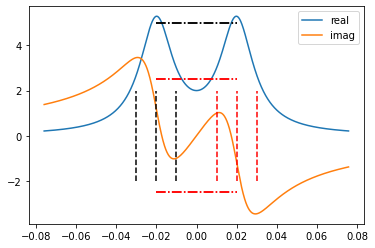

In [67]:
k = freq
s = 0.01
a = 0.02
c_r = 0.05
c_i = 0#.04
cc_r = 0.05
cc_i = 0#.06
c = c_r + c_i* 1j
cc = cc_r + cc_i * 1j

f = c /((s + a * 1j) + k *1j) + cc /((s - a * 1j) + k *1j)
C_t = c* np.exp(-(s + a * 1j)*learn_domain)
C_t_real = C_t.real
C_t_imag = C_t.imag
f_real = f.real
f_imag = f.imag

os.environ["KMP_DUPLICATE_LIB_OK"] = "True"
plt.plot(k, f_real, label = 'real')
plt.plot(k, f_imag, label = 'imag')

plt.vlines(x = [-a, -a+s, -a-s],ymin = -2, ymax = 2,color = 'k', linestyles = "--")
plt.vlines(x = [a, a+s, a-s],ymin = -2, ymax = 2, color = 'r', linestyles = "--")# for cc part
plt.hlines(y = [c_r/s, cc_r/s],xmin = -0.02, xmax = 0.02,color = 'k' , linestyles = "-.")
plt.hlines(y = [c_r/(2*s), cc_r/(2*s), -c_r/(2*s), -cc_r/(2*s)],xmin = -0.02, xmax = 0.02,color = 'r', linestyles = "-.")
#plt.hlines(y = [c_i/s, cc_i/s],xmin = -0.02, xmax = 0.02 , linestyles = "-.")
plt.legend()
plt.show()

In [6]:
learn_r = torch.Tensor(learn_s)
learn_i = torch.Tensor(learn_a)
learn = torch.complex(learn_r, learn_i)
init = learn[0]
learn = learn.detach().numpy()
print(init)

tensor(5.1622e-06-2.0515e-07j)


In [7]:
ft = fft(learn)
ft_shift = 2*np.pi*fftshift(ft)
ft_norm = (ft_shift*(ft_shift.conjugate()))/(integrate.simps(ft_shift*(ft_shift.conjugate()), dx = 5e-2))
n = np.arange(-n_pts/2, n_pts/2)
freq = 2*np.pi*(n/(n_pts*(learn_domain[1]-learn_domain[0])))

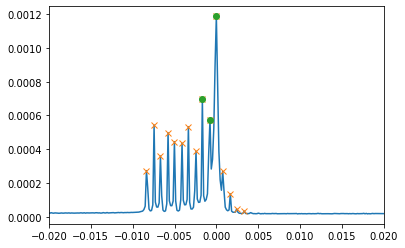

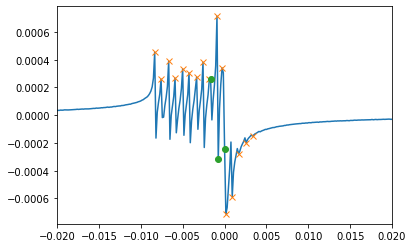

In [68]:
#find local maximum and local minimum
peak_ft_r, _ = signal.find_peaks(ft_shift.real, prominence = (0.01* max(ft_shift.real),))
peak_matching_real, _ = signal.find_peaks(ft_shift.real) # include more small peak that for the matching
#freq[peak_matching_real]
peak_ft_i, _ = signal.find_peaks(abs(ft_shift.imag), prominence = (0.01* max(abs(ft_shift.imag)),))
real_peaks = ft_shift[peak_ft_r].real
imag_peaks = ft_shift[peak_ft_i].imag
# find peaks in real part
select_real_peak = sorted(range(len(real_peaks)), key = lambda sub: real_peaks[sub])[-(dim):]
select_imag_peak = sorted(range(len(imag_peaks)), key = lambda sub: abs(imag_peaks[sub]))[-(dim):]

a_selected = freq[peak_ft_r[select_real_peak]] # place where a will occur # peak_ft_r[select_real_peak] indicate the position in freq space(cannot separate)
#_a_s = freq[peak_ft_i[select_imag_peak]] # place where -a+s or -a-s occur
plt.plot(freq, ft_shift.real)
plt.plot(freq[peak_ft_r], ft_shift[peak_ft_r].real, "x")
plt.plot(a_selected, ft_shift[peak_ft_r[select_real_peak]].real, "o")
plt.xlim(-0.02,0.02)
plt.show()
plt.plot(freq, ft_shift.imag)
plt.plot(freq[peak_ft_i], ft_shift[peak_ft_i].imag, "x")
plt.plot(a_selected, ft_shift[peak_ft_r[select_real_peak]].imag, "o")
plt.xlim(-0.02,0.02)
plt.show()

# initialize a

In [91]:
dim = 2
def find_closest(arr, val):
    idx = np.abs(arr - val).argmin()
    return idx, arr[idx]
# to find symm real peak positions # which indicate a value
posi_real_peak = np.where(freq[peak_ft_r] >0)
nega_real_peak = np.where(freq[peak_ft_r] <0)

if len(posi_real_peak[0]) > len(nega_real_peak[0]):
    #target_peak_posi = freq[peak_ft_r][nega_real_peak] # shorter one so no worries about the index
    target_peak_posi = freq[peak_ft_r][posi_real_peak] # no worries with above, now prefer matching with more pro
    target_peak_value = ft_shift[peak_ft_r][posi_real_peak].real
    match_peak_posi  = - freq[peak_matching_real]#freq[peak_ft_r][posi_real_peak]  # longer and complete one prominence peak
else:
    target_peak_posi = freq[peak_ft_r][nega_real_peak]
    target_peak_value = ft_shift[peak_ft_r][nega_real_peak].real
    match_peak_posi  = - freq[peak_matching_real] #freq[peak_ft_r][nega_real_peak]
    
a_array = np.zeros((len(target_peak_posi), ))
a_pair = np.zeros((len(target_peak_posi), 3)) # a, a reflection, peak value
for i in range(len(target_peak_posi)):
    idx, matched_peak_posi = find_closest(match_peak_posi, target_peak_posi[i])
    a_value = np.average([matched_peak_posi, target_peak_posi[i]])
    a_array[i] = a_value
    a_pair[i,0] = target_peak_posi[i]
    a_pair[i,1] = - matched_peak_posi
    a_pair[i,2] = target_peak_value[i]
#a_pair = a_pair.reshape(len(target_peak_posi), 2)
a_pair_sorted = a_pair[a_pair[:, 2].argsort()[::-1]] #from highest peak to lowest peak
a_actual = np.zeros((len(target_peak_posi), 2))
a = np.zeros((dim,))
if 0 in freq[peak_ft_r]:# means real FT peaked at 0
    dim += 1
    a = np.zeros((dim,))
    a[0] = 0
    a[1:dim] = a_array[:dim -1]
    save_a_actual = a_pair_sorted[:dim-1,:2]
    a_actual[0] = np.array([0,0])
    a_actual[1:dim] = save_a_actual
else:
    print("a = ", a_array[:dim])
    a = a_array[:dim]
    a_actual[:, :] = a_pair[:, :]
print(a_actual[:dim])
print(a_array[:dim])

[[ 0.          0.        ]
 [-0.00167014  0.00167014]
 [-0.00075915  0.00075915]]
[-0.00842662 -0.00743972 -0.00668056]


# initialize s

[[500 500]
 [489 511]
 [495 505]
 [451 549]]


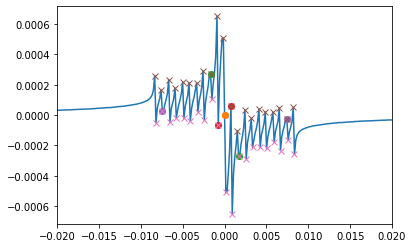

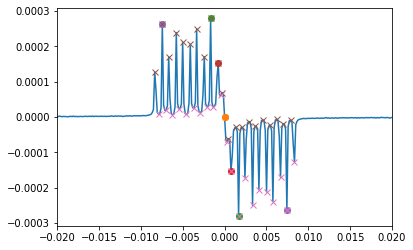

In [70]:
# posi_xxx nega_xxx indicate the peak is up or down
posi_r_ft_i_peak, _ = signal.find_peaks(ft_shift_r.imag, prominence = (0.01* max(ft_shift_r.imag),))
nega_r_ft_i_peak, _ = signal.find_peaks(-ft_shift_r.imag, prominence = (0.01* max(-ft_shift_r.imag),))
posi_i_ft_r_peak, _ = signal.find_peaks(ft_shift_i.real, prominence = (0.01* max(ft_shift_i.real),))
nega_i_ft_r_peak, _ = signal.find_peaks(-ft_shift_i.real, prominence = (0.01* max(-ft_shift_i.real),))

# c_i and cc_i is calculated from peak on ft_shift_r.imag
# c_r and cc_r is calculated from peak on ft_shift_i.real
# Thus, we must get s from the shared candidate peaks of two sequences above
if len(posi_r_ft_i_peak) < len(posi_i_ft_r_peak):
    shorter_posi_peak = posi_r_ft_i_peak
    longer_posi_peak = posi_i_ft_r_peak
else:
    shorter_posi_peak = posi_i_ft_r_peak
    longer_posi_peak = posi_r_ft_i_peak
    
if len(nega_r_ft_i_peak) < len(nega_i_ft_r_peak):
    shorter_nega_peak = nega_r_ft_i_peak
    longer_nega_peak = nega_i_ft_r_peak
else:
    shorter_nega_peak = nega_i_ft_r_peak
    longer_nega_peak = nega_r_ft_i_peak

shared_posi_peak = []#np.zeros_like(shorter_posi_peak)
shared_nega_peak = []#np.zeros_like(shorter_nega_peak)

for i, value in enumerate(shorter_posi_peak):
    shared_value = np.where(longer_posi_peak == value)
    if len(shared_value[0]) == 1:
        shared_posi_peak.append(longer_posi_peak[shared_value[0]][0])
for i, value in enumerate(shorter_nega_peak):
    shared_value = np.where(longer_nega_peak == value)
    if len(shared_value[0]) == 1:
        shared_nega_peak.append(longer_nega_peak[shared_value[0]][0])

plt.plot(freq, ft_shift_r.imag)

ft_shift_r_shift = scipy.interpolate.interp1d(freq, ft_shift_r.imag, bounds_error=False, fill_value=(0,0))

reshaped_a_actual = a_actual[:dim].reshape(dim*2,)
a_index = np.array([np.where(freq == i) for i in reshaped_a_actual]).reshape(dim,2)
print(a_index)


for i in range(dim):
    plt.plot(a_actual[i], ft_shift_r[a_index[i]].imag,"o")

plt.plot(freq[posi_r_ft_i_peak], ft_shift_r[posi_r_ft_i_peak].imag,"x")
plt.plot(freq[nega_r_ft_i_peak], ft_shift_r[nega_r_ft_i_peak].imag,"x")
#plt.plot(freq[shared_posi_peak], ft_shift_r[shared_posi_peak].imag,"D")
#plt.plot(freq[shared_nega_peak], ft_shift_r[shared_nega_peak].imag,"D")


plt.xlim(-0.02,0.02)
plt.show()

plt.plot(freq, ft_shift_i.real)
for i in range(dim):
    plt.plot(a_actual[i], ft_shift_i[a_index[i]].real,"o")
    
plt.plot(freq[posi_i_ft_r_peak], ft_shift_i[posi_i_ft_r_peak].real,"x")
plt.plot(freq[nega_i_ft_r_peak], ft_shift_i[nega_i_ft_r_peak].real,"x")
#plt.plot(freq[shared_posi_peak], ft_shift_i[shared_posi_peak].real,"D")
#plt.plot(freq[shared_nega_peak], ft_shift_i[shared_nega_peak].real,"D")
plt.xlim(-0.02,0.02)
plt.show()

In [13]:
print(freq[posi_r_ft_i_peak])
print(freq[posi_i_ft_r_peak])

[-0.0083507  -0.00759155 -0.00668056 -0.00592141 -0.00501042 -0.00425127
 -0.00334028 -0.00258113 -0.00167014 -0.00091099 -0.00015183  0.00075915
  0.00151831  0.0024293   0.00318845  0.00409944  0.00485859  0.00576958
  0.00652873  0.00743972  0.00819887]
[-0.0083507  -0.00743972 -0.00668056 -0.00576958 -0.00501042 -0.00409944
 -0.00334028 -0.0024293  -0.00167014 -0.00075915 -0.00030366  0.00045549
  0.00136648  0.00212563  0.00288479  0.00364394  0.00455493  0.00546592
  0.00622507  0.00698423  0.00789521]


 from the diagram above we can find that there will be a positive peak and its coupled negative peak
 so use the positive one to match the negative one.
 the matched peak pairs should satidfied:
1. have same distance(s value) to the a_value 
2. since a_value appears to be into the positive and negative pair so the 4 s_value should be the same
3. if there will be more than one choice, choose the smaller one, due to the function properties(smaller s more wave peak after ifft)

Firstly, use this graph "ft_shift_r.imag" since its peak is more easy to realize\
Then, do some matching and make sure to capture the peak on "ft_shift_i.real"

a_value determines the frequency of oscillation: larger a higher frequency

s_value determines the duration of the oscillaton: larger s shorter duration

frequency must be different, duration can be the same

In [71]:
s = np.zeros((dim,2))#2 comes from: one is for a one is for s
for i in range(dim):
    #a_actual[i] is one pair of a_values
    for_row_num_compare = np.zeros((2,))
    for j in range(2): #not dim since a_value is in pairs
        #a_actual[i][j] is one a_value in one pair of a_values
        #since the element of pair are on the opposite site of the a_value
        if j == 0: #have to do some initialization
            available_posi_peak = np.where(freq[posi_r_ft_i_peak]< a_actual[i][j])
            available_nega_peak = np.where(freq[nega_r_ft_i_peak]> a_actual[i][j])
            # use the longer list to be the pool which the paired value are selected from
            # use the shorter list to be the target
            compare_a1 = np.zeros((len(available_posi_peak[0]), 3))# each peak have a mirror peak, 3rd is dist(s_value)
            compare_a2 = np.zeros((len(available_nega_peak[0]), 3))
        ### above is to solve problems that either compare_a1 or compare_a2 will be zero previously
    
        if len(available_posi_peak[0]) < len(available_nega_peak[0]):# negative peaks will be the pool
            for_row_num_compare[j] = len(available_posi_peak[0])
            #print(a_actual[i][j], j,1)
            for k, value in enumerate(freq[posi_r_ft_i_peak][available_posi_peak]):
                dist = a_actual[i][j] - value
                matched_position = a_actual[i][j] + dist # an ideal position for negative peak (with some position logic) 
                idx, matched_peak_posi = find_closest(freq[nega_r_ft_i_peak], matched_position)
                filled_array = compare_a1
                filled_array[k,0] = value #positive at position 0
                filled_array[k,1] = matched_peak_posi #negative peak at position 1
                filled_array[k,2] = abs(dist)
            # sort to find the closest pair use argsort to dist
            compare_a1_sorted = compare_a1[compare_a1[:, 2].argsort()] 
            
            
        elif len(available_posi_peak[0]) > len(available_nega_peak[0]):# positive peaks will be the pool
            for_row_num_compare[j] = len(available_nega_peak[0])
            for k, value in enumerate(freq[nega_r_ft_i_peak][available_nega_peak]):
                dist = a_actual[i][j] - value
                matched_position = a_actual[i][j] + dist
                idx, matched_peak_posi = find_closest(freq[posi_r_ft_i_peak], matched_position)
                filled_array = compare_a2
                filled_array[k,1] = value
                filled_array[k,0] = matched_peak_posi
                filled_array[k,2] = abs(dist)
            compare_a2_sorted = compare_a2[compare_a2[:, 2].argsort()]
        
        elif len(available_posi_peak[0]) == len(available_nega_peak[0]):
            if j == 0:
                for_row_num_compare[j] = len(available_posi_peak[0])
                for k, value in enumerate(freq[posi_r_ft_i_peak][available_posi_peak]):
                    dist = a_actual[i][j] - value
                    matched_position = a_actual[i][j] + dist # an ideal position for negative peak
                    idx, matched_peak_posi = find_closest(freq[nega_r_ft_i_peak], matched_position)
                    filled_array = compare_a1
                    filled_array[k,0] = value
                    filled_array[k,1] = matched_peak_posi
                    filled_array[k,2] = abs(dist)
                compare_a1_sorted = compare_a1[compare_a1[:, 2].argsort()]
            else:
                for_row_num_compare[j] = len(available_nega_peak[0])
                for k, value in enumerate(freq[nega_r_ft_i_peak][available_nega_peak]):
                    dist = value - a_actual[i][j]
                    matched_position = a_actual[i][j] + np.abs(dist)
                    idx, matched_peak_posi = find_closest(freq[posi_r_ft_i_peak], matched_position)
                    filled_array = compare_a2
                    filled_array[k,1] = value
                    filled_array[k,0] = matched_peak_posi
                    filled_array[k,2] = abs(dist)
                compare_a2_sorted = compare_a2[compare_a2[:, 2].argsort()]
    # so far, for one i there will be one compare_a2_sorted and one compare_a1_sorted
            

    # now we have some pair candidates, then have to make sure point 2
    #since a_actual[i] is positive then negative so for_row_num_compare is [len(available_nega_peak), len(available_posi_peak)]
    #similar idea: use larger list as pool
    
    # if a >0 matched more, compare_a2 shorter
    if len(compare_a2_sorted[:,2]) < len(compare_a1_sorted[:,2]):
        for_step_2 = np.zeros((len(compare_a2_sorted[:,2]), 3)) # s, s', diff
        for k, value in enumerate(compare_a2_sorted[:,2]): #start from the lowest s value
            idx, matched_s = find_closest(compare_a1[:,2], value)
            for_step_2[k,2] = abs(value - matched_s)
            if for_step_2[k,2] >= value/2:
                for_step_2[k,0] = 10
            else:
                for_step_2[k,0] = value
                for_step_2[k,1] = matched_s#compare_a1[:,2][idx]
        step_2_sorted = for_step_2[for_step_2[:, 0].argsort()]
        #step_2_sorted = for_step_2[for_step_2[:, 2].argsort()]  # not good need a balance between small s and same s
        
    else:#compare_a1 shorter or equal
        for_step_2 = np.zeros((len(compare_a1_sorted[:,2]), 3))
        for k, value in enumerate(compare_a1_sorted[:,2]): 
            idx, matched_s = find_closest(compare_a2_sorted[:,2], value)
            for_step_2[k,2] = abs(value - matched_s)
            if for_step_2[k,2] >= value/2:
                for_step_2[k,0] = 10
            else:
                for_step_2[k,0] = value
                for_step_2[k,1] = matched_s
        step_2_sorted = for_step_2[for_step_2[:, 0].argsort()]
    smallest_diff_smallest_s = step_2_sorted[0]# with smallest diff and smallest s_value
    
    avg_s = np.average(smallest_diff_smallest_s[:2])
    print(smallest_diff_smallest_s[:2])
    s[i, 0] = a_actual[i][1]
    s[i, 1] = avg_s
print(s[:,1])
    # want different s_value for different a_value
    # we want longer duration happen in lower frequency
    # smaller s_value with smaller a_value
#    if i != 0: #it is not the smallest a_value
#        idx_next_s = 0
#        x = 0
#        while x < i:
#            x +=1
#            previous_s = round(s[x,1], 10)
#            current_s = round(s[i,1], 10)
#            #while previous_s == current_s: # we have same s_value, need to look for the next
#            if previous_s == current_s:
#                idx_next_s += 1
#                smallest_diff_smallest_s = step_2_sorted[idx_next_s]# with smallest diff and smallest s_value
#                avg_s = np.average(smallest_diff_smallest_s[:2])
#                s[i, 0] = a_actual[i][1]
#               s[i, 1] = avg_s

[0.00015183 0.00015183]
[0.00425127 0.00425127]
[0.00167014 0.00167014]
[0.01503127 0.0083507 ]
[0.00015183 0.00425127 0.00167014 0.01169099]


Issue: either compared_a1 or a_2 will be an empty list

In [12]:
print(a_actual[:dim])
print(a_actual[:dim][:,0] + s[:,1])
print(a_actual[:dim][:,0] - s[:,1])
print(a_actual[:dim][:,1] + s[:,1])
print(a_actual[:dim][:,1] - s[:,1])

[[ 0.          0.        ]
 [-0.00167014  0.00167014]
 [-0.00075915  0.00075915]]
[0.00015183 0.00258113 0.00091099]
[-0.00015183 -0.00592141 -0.0024293 ]
[0.00015183 0.00592141 0.0024293 ]
[-0.00015183 -0.00258113 -0.00091099]


# initialize Cr Ci CCr CCi

This part still has some problem
1. I got wrong s value
2. I got wrong in initialized C

1. need to solve
2. have the correct theory but need to code that

In [72]:
#make them as functions that can find value given k
ft_shift_i_k = scipy.interpolate.interp1d(freq, ft_shift.imag, bounds_error=False, fill_value=(0,0))
ft_shift_r_k = scipy.interpolate.interp1d(freq, ft_shift.real, bounds_error=False, fill_value=(0,0))
ft_shift_rr_k = scipy.interpolate.interp1d(freq, ft_shift_r.real, bounds_error=False, fill_value=(0,0))
ft_shift_ir_k = scipy.interpolate.interp1d(freq, ft_shift_i.real, bounds_error=False, fill_value=(0,0))
ft_shift_ii_k = scipy.interpolate.interp1d(freq, ft_shift_i.imag, bounds_error=False, fill_value=(0,0))
ft_shift_ri_k = scipy.interpolate.interp1d(freq, ft_shift_r.imag, bounds_error=False, fill_value=(0,0))

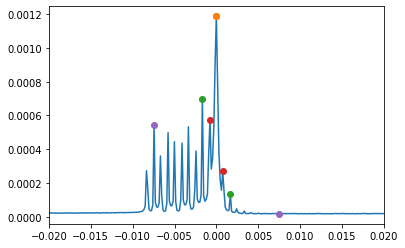

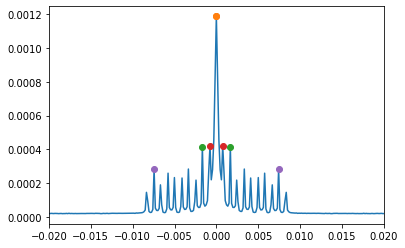

In [73]:
plt.plot(freq, ft_shift.real)
for i in range(dim):
    plt.plot(a_actual[i], ft_shift[a_index[i]].real,"o")
plt.xlim(-0.02, 0.02)
plt.show()

plt.plot(freq, ft_shift_r.real)
for i in range(dim):
    plt.plot(a_actual[i], ft_shift_r[a_index[i]].real,"o")
plt.xlim(-0.02, 0.02)
plt.show()

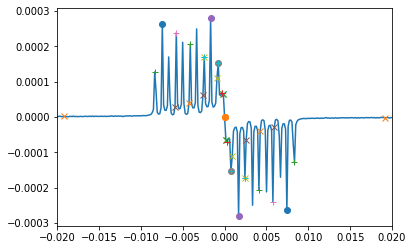

In [74]:
#round(s[:,1][0], 10) ==round(s[:,1][1], 10) 
#print(a_actual)
plt.plot(freq, ft_shift_i.real)
a_s_ri = np.zeros((dim, 4)) # there will be 4 value prerow
a_s_ir = np.zeros((dim, 4))
s_ir = np.zeros((dim,)) # the s value may changed accordingly
for i in range(dim):
    plt.plot(a_actual[i], ft_shift_i[a_index[i]].real,"o")
    a_s_ri[i] = np.array([a_actual[i,0]+s[i,1], a_actual[i,0]-s[i,1], a_actual[i,1]+s[i,1], a_actual[i,1]-s[i,1]])
    plt.plot(a_s_ri[i], ft_shift_ir_k(a_s_ri[i]),"x")
    #print(a_s, ft_shift_ir_k(a_s))
    for j, value in enumerate(a_s_ri[i]):
        if ft_shift_ir_k(a_s_ri[i][j]) > 0:
            shared_value = np.where(freq[posi_i_ft_r_peak] == value)
            if len(shared_value[0]) == 0:
                idx, nearest_peak = find_closest(freq[posi_i_ft_r_peak], value)
                a_s_ir[i][j] = nearest_peak
            else:
                a_s_ir[i][j] = value
        if ft_shift_ir_k(a_s_ri[i][j]) < 0: # peak cannot equal to zero so only two case
            shared_value = np.where(freq[nega_i_ft_r_peak] == value)
            if len(shared_value[0]) == 0:
                idx, nearest_peak = find_closest(freq[nega_i_ft_r_peak], value)
                a_s_ir[i][j] = nearest_peak
            else:
                a_s_ir[i][j] = value
    s_ir[i] = np.average(np.abs(a_s_ir[i]) - a_actual[i,0])
    plt.plot(a_s_ir[i], ft_shift_ir_k(a_s_ir[i]),"+") # that is the peak we want
    
plt.xlim(-0.02, 0.02)
plt.show()

From the characteristic of the real and imag part of the transfored function, we can see that the coeffs can be extracted from the function:

Noticed that, the real part can be decomposed into two part:
1. contributed by c_r
2. contributed by c_i

the real part coeffs c_r and cc_r can be find from idea that\
in ft_shift_r.real $peak = \frac{\frac{c_r + cc_r}{2}}{s}= \frac{c_r + cc_r}{2s}$

in ft_shift_i.real $peak = \frac{\frac{c_r - cc_r}{2}}{2s} = \frac{c_r - cc_r}{4s}$

the imag part coeffs c_i and cc_i can be find from idea that\
in ft_shift_i.imag $peak = \frac{\frac{c_i + cc_i}{2}}{s} = \frac{c_i + cc_i}{2s}$

in ft_shift_r.imag $peak = \frac{\frac{cc_i - c_i}{2}}{2s} = - \frac{c_i - cc_i}{4s}$

In [75]:
c_r = np.zeros((dim,))
cc_r = np.zeros((dim,))
c_i = np.zeros((dim,))
cc_i = np.zeros((dim,))
c_rpcc_r = np.zeros((dim,))
c_rmcc_r = np.zeros((dim,))# since a_s is dim x 4 shape
c_ipcc_i = np.zeros((dim,)) 
c_imcc_i = np.zeros((dim,))
for i in range(dim):
    s_i = s[:,1][i]
    c_rpcc_r[i] = np.average(ft_shift_r[a_index[i]].real * 2 * s_i)
    c_ipcc_i[i] = np.average(ft_shift_i[a_index[i]].imag * 2 * s_ir[i]) # use s_ir when we encounter ft_shift_i
    c_rmcc_r[i] = ft_shift_ir_k(a_s_ri[i][0]) * 4 * s_i - c_ipcc_i[i]
    c_imcc_i[i] = -(ft_shift_ri_k(a_s_ri[i][0]) * 4 * s_ir[i] - c_rpcc_r[i])

print(c_rpcc_r)
print(c_rmcc_r)
print(c_ipcc_i)
print(c_imcc_i)
c_r = (c_rpcc_r+c_rmcc_r)/2
c_i = (c_ipcc_i+c_imcc_i)/2
cc_r = (c_rpcc_r-c_rmcc_r)/2
cc_i = (c_ipcc_i-c_imcc_i)/2
# some c_imcc_i  and c_rmcc_r are not same
# so we need to further process them
# due to c_imcc_i comes from a_s_ri which it will envolves two pairs
# each pair has a upper value and a lower value
# for example ft_shift_ri_k,
# left peak indicate (1/4s)(c_rpcc_r + c_imcc_i) right peak indicate (1/4s)(c_rpcc_r - c_imcc_i)

r_sum = np.sum(c_r) + np.sum(cc_r)

c_r = c_r/r_sum * init.real.detach().numpy()
cc_r = cc_r/r_sum * init.real.detach().numpy()
print('-------------------')
print(c_r)
print(cc_r)
print(c_i)
print(cc_i)

[3.60608908e-07 3.53430642e-06 1.40993325e-06 6.57876535e-06]
[ 1.08497111e-07 -9.69871722e-07  4.61358857e-07 -6.59353645e-07]
[-1.47884691e-07 -1.11864090e-07 -1.20500533e-06 -1.20357981e-06]
[9.78048164e-07 1.02394377e-05 7.53676400e-06 1.81726252e-05]
-------------------
[1.01888930e-07 5.56990311e-07 4.06441066e-07 1.28568490e-06]
[5.47582002e-08 9.78298877e-07 2.06028543e-07 1.57210560e-06]
[4.15081736e-07 5.06378683e-06 3.16587933e-06 8.48452268e-06]
[-5.62966427e-07 -5.17565091e-06 -4.37088467e-06 -9.68810249e-06]


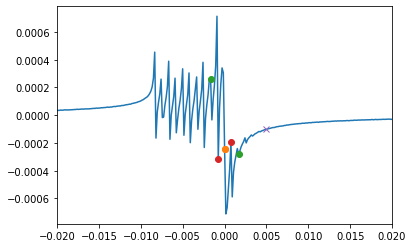

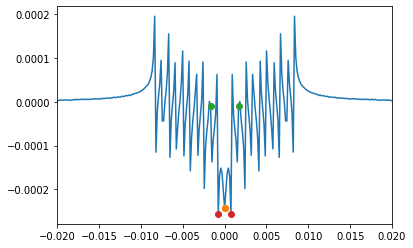

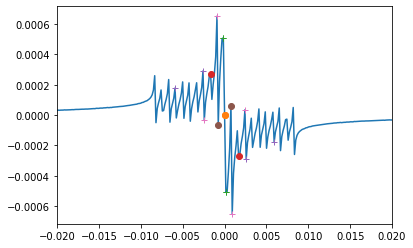

In [111]:
plt.plot(freq, ft_shift.imag)
for i in range(dim):
    plt.plot(a_actual[i], ft_shift[a_index[i]].imag,"o")
    
#plt.plot(-(a_array[:dim]+s[:,1]), ft_shift_i_k(-(a_array[:dim]+s[:,1])), 'x')
#plt.plot((a_array[:dim]+s[:,1]), ft_shift_i_k((a_array[:dim]+s[:,1])), 'x')
plt.plot(0.005, ft_shift_i_k(0.005), 'x')
plt.xlim(-0.02, 0.02)
plt.show()

plt.plot(freq, ft_shift_i.imag)
for i in range(dim):
    plt.plot(a_actual[i], ft_shift_i[a_index[i]].imag,"o")
plt.xlim(-0.02, 0.02)
plt.show()

plt.plot(freq, ft_shift_r.imag)
for i in range(dim):
    plt.plot(a_actual[i], ft_shift_r[a_index[i]].imag,"o")
    a_s = [a_actual[i,0]+s[i,1], a_actual[i,0]-s[i,1], a_actual[i,1]+s[i,1], a_actual[i,1]-s[i,1]]
    plt.plot(a_s, ft_shift_ri_k(a_s),"+")
plt.xlim(-0.02, 0.02)
plt.show()

In [63]:
for i in range(dim):
    s_i = s[:,1][i]
    #c_i[i], cc_i[i] = ft_shift[a_index[i]].imag * (2*s_i)
    movefunc = ft_shift_i_k(-a[i]-s_i) - ft_shift_i_k(-a[i])
    c_i[i] = movefunc * (2*s_i)
    cc_i[i] = -c_i[i]
print(c_i)
print(cc_i)
i_sum = np.sum(c_i) + np.sum(cc_i)
i_correction = (init.imag - i_sum).detach().numpy()
c_i += i_correction/(dim * 2)
cc_i += i_correction/(dim * 2)
print(c_i)
print(cc_i)
print(np.sum(c_i) + np.sum(cc_i))

[ 4.16507677e-08 -2.89640601e-09 -2.28409955e-10]
[-4.16507677e-08  2.89640601e-09  2.28409955e-10]
[ 7.45895862e-09 -3.70882151e-08 -3.44202190e-08]
[-7.58425768e-08 -3.12954031e-08 -3.39633991e-08]
-2.0515085452643686e-07


In [65]:
print(a_actual[:dim, 1])
print(a_array[:dim])

[0.         0.00167014 0.00075915]
[-0.00842662 -0.00743972 -0.00668056]


# star NN

In [76]:
a_torch = torch.tensor(a_actual[:dim, 1])#, requires_grad=True)
s_torch = torch.tensor(s[:,1])#, requires_grad=True)
c_r_np = np.zeros((dim*2,))
c_r_np[:dim] = c_r
c_r_np[dim:] = cc_r
c_r_torch = torch.tensor(c_r_np)#, requires_grad=True)
c_i_np = np.zeros((dim*2,))
c_i_np[:dim] = c_i
c_i_np[dim:] = cc_i
c_i_torch = torch.tensor(c_i_np)#, requires_grad=True)

In [82]:
class Func_r_i(nn.Module):
    def __init__(self, dim, init, c_r, c_i, eta_r, eta_i):
        super().__init__()
        self.dim = dim
        scale  = 1e-6
        self.init_r = init.real
        self.init_i = init.imag
        self.c_i = nn.Parameter(c_r[:dim*2-1].clone().detach().requires_grad_(True))#nn.Parameter(torch.rand(self.dim * 2 - 1, requires_grad=True)*scale)
        self.c_r = nn.Parameter(c_i[:dim*2-1].clone().detach().requires_grad_(True))#nn.Parameter(torch.rand(self.dim * 2 - 1, requires_grad=True)*scale)
        #self.eta_i = nn.Parameter(eta_i.clone().detach().requires_grad_(True))
        self.eta_r = nn.Parameter(eta_r.clone().detach().requires_grad_(True))#nn.Parameter(torch.rand(self.dim, requires_grad=True)*scale)
        #self.eta_r = eta_r
        self.eta_i = eta_i
        return

    def forward(self, t):
        t0 = torch.unsqueeze(t, -1)
        t = torch.unsqueeze(t, -1).expand(-1, self.dim)
        #print(torch.sum(self.c_r))
        c_r_correction = self.init_r - torch.sum(self.c_r) # to let real and imag part have the correct inital value
        c_i_correction = self.init_i - torch.sum(self.c_i)
        #c = torch.complex(self.c_r, self.c_i)
        c = torch.zeros((self.dim * 2,), dtype = torch.complex128)
        c[-1:] = torch.complex(c_r_correction, c_i_correction)
        c[:-1] = torch.complex(self.c_r, self.c_i)
        #if torch.max(torch.abs(self.eta_r)) - torch.min(torch.abs(self.eta_r)) <= torch.min(torch.abs(self.eta_r)):
        #eta = torch.complex(-torch.abs(self.eta_r), self.eta_i)
        eta = torch.complex(self.eta_r, self.eta_i)
        #else:
        #    for i in range(len(self.eta_r)):
        #        if torch.abs(self.eta_r[i]) - torch.min(torch.abs(self.eta_r)) <= torch.min(torch.abs(self.eta_r)):
        #            self.eta_r[i].clone()
        #            self.eta_r[i] = 2 * torch.min(torch.abs(self.eta_r)).detach()
        self.eta = eta
        self.c = c
        i = torch.complex(torch.zeros((1)),torch.ones((1)))
        c_t = c[:self.dim]* torch.exp(eta * t) + c[self.dim:]* torch.exp(torch.conj(eta) * t)
        
        
        return torch.sum(c_t, dim = -1)

In [86]:
network_t = Func_r_i(dim, init, c_r_torch, c_i_torch, -s_torch, -a_torch)
loss_list = []

optimizer_d_r_i = optim.Adam(network_t.parameters(), lr=5e-9)
#learn_domain_tensor = torch.tensor(learn_domain_short).float()
#learn = torch.complex(torch.tensor(learn_s_short), torch.tensor(learn_a_short))
learn_domain_tensor = torch.tensor(learn_domain).float()
learn = torch.complex(torch.tensor(learn_s), torch.tensor(learn_a))

lossfunc = nn.L1Loss() #nn.MSELoss()
for n in range(14000):
    _sum = network_t(learn_domain_tensor)
    if n == 0:
        initial_value = _sum.detach().clone()
        print(network_t.eta)
        print(network_t.c)
    loss = lossfunc(_sum, learn)
    #loss_i = lossfunc(hat_d_i, learn_i)
    #loss = loss_r + loss_i
    
    loss_list.append(loss.item())
    
    optimizer_d_r_i.zero_grad()   
    loss.backward()
    optimizer_d_r_i.step()
    if (n)%2000 == 0:
        print(f"{n}: {loss.item()}")

tensor(-0.0002, dtype=torch.float64, grad_fn=<SelectBackward0>)
tensor([ 4.1508e-07+1.0189e-07j,  5.0638e-06+5.5699e-07j,
         3.1659e-06+4.0644e-07j,  8.4845e-06+1.2857e-06j,
        -5.6297e-07+5.4758e-08j, -5.1757e-06+9.7830e-07j,
        -4.3709e-06+2.0603e-07j, -1.8576e-06-3.7952e-06j],
       dtype=torch.complex128, grad_fn=<CopySlices>)
0: 3.138363820405086e-07
2000: 1.8022214488573547e-07
4000: 1.7544558680267653e-07
6000: 1.7419288088609013e-07
8000: 1.730803305254856e-07
10000: 1.7221824762079604e-07
12000: 1.715207216313108e-07


In [87]:
eta = network_t.eta
c = network_t.c
print(eta)
print(c)

tensor([-0.0002-0.0000j, -0.0043-0.0017j, -0.0017-0.0008j, -0.0117-0.0074j],
       dtype=torch.complex128, grad_fn=<ComplexBackward0>)
tensor([ 1.0279e-06-3.2945e-08j,  1.6891e-05-1.4852e-05j,
         3.5733e-06+6.3260e-06j, -5.5944e-06-3.4700e-06j,
         4.9839e-08-8.0076e-08j, -6.0839e-06+8.2828e-06j,
        -2.0827e-06+2.6795e-07j, -2.6189e-06+3.3530e-06j],
       dtype=torch.complex128, grad_fn=<CopySlices>)


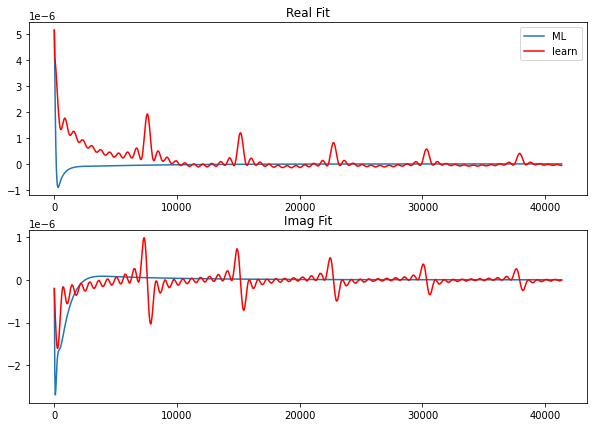

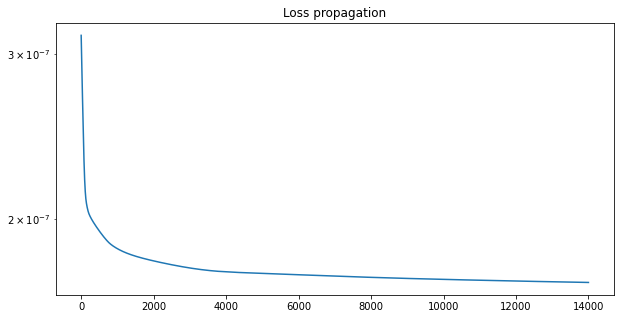

In [88]:
final_value = network_t(learn_domain_tensor)#torch.tensor(test_domain))
plot_r = initial_value.real
plot_i = initial_value.imag
plt.figure(figsize = (10,7))
ax1 = plt.subplot(211)
ax1.set_title('Real Fit')
#ax1.set_xscale('log')
ax1.plot(learn_domain, plot_r.detach().numpy().flatten(),label ='ML')
#ax1.plot(learn_domain, initial_value.real.detach().numpy().flatten())
#ax1.plot(learn_domain_short, learn_s_short, 'r-',label ='learn')
ax1.plot(learn_domain, learn_s, 'r-',label ='learn')
#ax1.plot(test_domain, test_s, 'y-',label ='test')
ax1.legend()

ax2 = plt.subplot(212, sharex=ax1)
ax2.set_title('Imag Fit')
#ax2.set_xscale('log')
ax2.plot(learn_domain, plot_i.detach().numpy().flatten(),label ='ML')
ax2.plot(learn_domain, learn_a , 'r-',label ='learn')#
#ax2.plot(test_domain, test_a, 'y-',label ='learn')
plt.show()

plt.figure(figsize = (10,5))
plt.title('Loss propagation')
plt.yscale('log')
plt.plot(loss_list,label ='Loss')
plt.show()

From that we can see that, there may still need to add an exponential $(c_r+c_ii)exp(-st)$
which means the c_r and c_i for the a=0 peak is not so correct,
problem might be:
1. s is incorrect
2. s is correct but c is incorrect

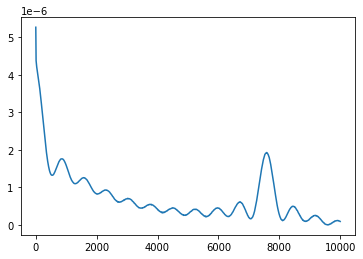

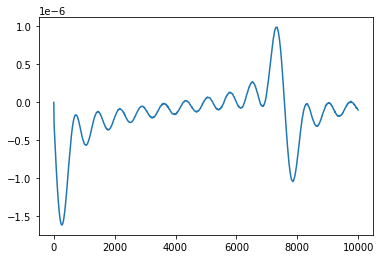

1000


In [6]:
file_learn_short = open('learn_db_10_short.csv', 'r')
learn_s_short, test_s_short,learn_a_short, test_a_short = np.loadtxt(file_learn_short ,delimiter = ",")
plt.plot(learn_domain_short, learn_s_short)
#plt.xscale('log')
plt.show()
plt.plot(learn_domain_short, learn_a_short)
#plt.xscale('log')
plt.show()
print(len(learn_domain_short))